<a href="https://colab.research.google.com/github/Nov05/yelp-dataset-challenge/blob/master/notebooks/2019_12_10_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# created by nov05 on 2019-12-10

https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!pip install pytorch_pretrained_bert
# Successfully installed pytorch-pretrained-bert-0.6.2 regex-2019.12.9

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 2577715.00B/s]


In [9]:
path = "/content/drive/My Drive/data/2019-12-06 yelp/yelp_dataset/csv_out/tip.csv"
df_tip = pd.read_csv(path)
print(df_tip.shape)
df_tip.sample(3)

(1223094, 5)


,user_id,business_id,text,date,compliment_count
1122599,NkgHjC9Yogw5y42NJ5dSTg,Bh3duLU3aASnt2TZ97TJnQ,"Was closed at 8:20 SEPT 27, 2017",2017-09-27 15:23:31,0
596378,uegNuvRUU-z4FwFo2aJpcw,Queaai26YT4YWUd_b_6gAg,Love this place. I believe it's the best office.,2013-05-31 15:54:15,0
297253,F2IbnY4CpTfSxQijPtDKKg,uGupeWqih0yIcCg8anM1PA,"Audition time: show'em how it's done, SON! haha",2010-10-29 05:25:04,0


In [17]:
text = df_tip.sample()['text'].values[0]
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)
# the BERT tokenizer was created with a WordPiece model

['[CLS]', 'service', 'was', 'awesome', 'drinks', 'were', 'strong', 'and', 'ta', '##sty', '.', 'food', 'was', 'great', '[SEP]']


In [18]:
# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
service       2,326
was           2,001
awesome      12,476
drinks        8,974
were          2,020
strong        2,844
and           1,998
ta           11,937
##sty        21,756
.             1,012
food          2,833
was           2,001
great         2,307
[SEP]           102


In [19]:
# Mark each of the 22 tokens as belonging to sentence "1".
segments_ids = [1] * len(tokenized_text)
print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [20]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

100%|██████████| 407873900/407873900 [00:08<00:00, 49890377.48B/s]


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Lin

In [0]:
# Predict hidden states features for each layer
with torch.no_grad():
    encoded_layers, _ = model(tokens_tensor, segments_tensors)

In [22]:
print ("Number of layers:", len(encoded_layers))
layer_i = 0
print ("Number of batches:", len(encoded_layers[layer_i]))
batch_i = 0
print ("Number of tokens:", len(encoded_layers[layer_i][batch_i]))
token_i = 0
print ("Number of hidden units:", len(encoded_layers[layer_i][batch_i][token_i]))

Number of layers: 12
Number of batches: 1
Number of tokens: 15
Number of hidden units: 768


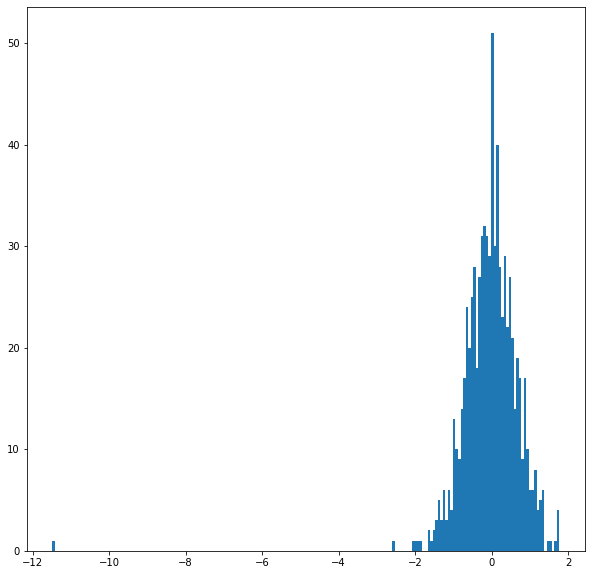

In [24]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = encoded_layers[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [25]:
# `encoded_layers` is a Python list.
print('     Type of encoded_layers: ', type(encoded_layers))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', encoded_layers[0].size())

     Type of encoded_layers:  <class 'list'>
Tensor shape for each layer:  torch.Size([1, 15, 768])


In [26]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(encoded_layers, dim=0)
token_embeddings.size()

torch.Size([12, 1, 15, 768])

In [27]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)
token_embeddings.size()

torch.Size([12, 15, 768])

In [28]:
# switch around the “layers” and “tokens” dimensions
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)
token_embeddings.size()

torch.Size([15, 12, 768])

In [29]:
# Stores the token vectors, with shape [15 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [15 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 15 x 3072


In [30]:
# Stores the token vectors, with shape [15 x 768]
token_vecs_sum = []

# `token_embeddings` is a [15 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 15 x 768


# Sentence Vectors

In [32]:
# `encoded_layers` has shape [12 x 1 x 22 x 768]

# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = encoded_layers[11][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

print ("Our final sentence embedding vector of shape:", sentence_embedding.size())

Our final sentence embedding vector of shape: torch.Size([768])


In [33]:
for i, token_str in enumerate(tokenized_text):
    print (i, token_str)

0 [CLS]
1 service
2 was
3 awesome
4 drinks
5 were
6 strong
7 and
8 ta
9 ##sty
10 .
11 food
12 was
13 great
14 [SEP]


In [35]:
print('First 5 vector values for 3 adjectives.')
print("awesome ", str(token_vecs_sum[3][:5]))
print("strong ", str(token_vecs_sum[6][:5]))
print("great ", str(token_vecs_sum[13][:5]))

First 5 vector values for 3 adjectives.
awesome  tensor([3.2793, 0.4395, 0.4706, 3.9851, 3.3688])
strong  tensor([-2.8577, -2.6828,  2.8643,  2.7328,  2.1268])
great  tensor([-0.0675,  0.7492, -1.2852,  3.2361,  1.3994])


In [36]:
from scipy.spatial.distance import cosine

# difference between "awesome" and "great" in this sentence
diff_1 = 1 - cosine(token_vecs_sum[3], token_vecs_sum[13])
# difference between "awesome" and "strong" in this sentence
diff_2 = 1 - cosine(token_vecs_sum[3], token_vecs_sum[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % diff_1)
print('Vector similarity for *different* meanings:  %.2f' % diff_2)

Vector similarity for  *similar*  meanings:  0.84
Vector similarity for *different* meanings:  0.55
